In [1]:
%tensorflow_version 1.4.1

import tensorflow
print(tensorflow.__version__)

import os
from google.colab import drive
drive.mount('/content/gdrive')

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.4.1`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
1.15.2
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!git clone https://github.com/JT1316/UNetPlusPlus.git
%cd UNetPlusPlus
#!pip install -r requirements.txt
!git submodule update --init --recursive

Cloning into 'UNetPlusPlus'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 638 (delta 9), reused 0 (delta 0), pack-reused 616
Receiving objects: 100% (638/638), 5.84 MiB | 30.19 MiB/s, done.
Resolving deltas: 100% (330/330), done.
/content/UNetPlusPlus


In [3]:
import numpy as np
import keras
np.random.seed(123)  # for reproducibility
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Layer, Input, Lambda 
from keras.layers import Multiply, Add, BatchNormalization, Reshape
from keras.layers import UpSampling2D, Convolution2D, LeakyReLU, Flatten, ReLU

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from keras.datasets import mnist
from keras import backend as K
from scipy.stats import norm

import matplotlib.image as mpimg
import sys

from tqdm import tqdm_notebook
from IPython import display
%matplotlib inline

from keras import initializers
from keras.optimizers import Adam
from keras.layers.convolutional import Conv2D

Using TensorFlow backend.


In [3]:
orig_dir = '/content/gdrive/My Drive/NEUTROPHIL/Train/240/240'
print('total images:', len(os.listdir(orig_dir)))
temp = os.listdir(orig_dir)

total images: 4002


In [0]:
valid_dir = '/content/gdrive/My Drive/NEUTROPHIL/Valid/240/240'
print('total images:', len(os.listdir(valid_dir)))
temp_valid = os.listdir(orig_dir)

total images: 996


In [0]:
test_dir = '/content/gdrive/My Drive/NEUTROPHIL/Test/240/240'
print('total images:', len(os.listdir(test_dir)))
test_valid = os.listdir(test_dir)

In [4]:
import tensorflow
from keras.preprocessing.image import ImageDataGenerator

# Rescale
train_datagen = ImageDataGenerator(rescale=1./255)
train_dir_in = '/content/gdrive/My Drive/NEUTROPHIL/Train/240'

image_generator = train_datagen.flow_from_directory(
        train_dir_in,  # Source
        target_size=(224, 224),  # All images will be resized to 240x240
        batch_size= 16,
        color_mode="rgb",
        class_mode=None,
        shuffle=False
        )


Found 4002 images belonging to 1 classes.


In [5]:
# Rescale
valid_datagen = ImageDataGenerator(rescale=1./255)
valid_dir_in = '/content/gdrive/My Drive/NEUTROPHIL/Valid/240'

image_generator_valid = valid_datagen.flow_from_directory(
        valid_dir_in,  # Source
        target_size=(224, 224),  # All images will be resized to 32x32
        batch_size= 16,
        color_mode="rgb",
        class_mode=None,
        shuffle=False
        )

Found 996 images belonging to 1 classes.


In [6]:
# Rescale
test_datagen = ImageDataGenerator(rescale=1./255)
test_dir_in = '/content/gdrive/My Drive/NEUTROPHIL/Test/240'

image_generator_test = test_datagen.flow_from_directory(
        test_dir_in,  # Source
        target_size=(224, 224),  # All images will be resized to 32x32
        batch_size= 16,
        color_mode="rgb",
        class_mode=None,
        shuffle=False
        )

Found 1248 images belonging to 1 classes.


In [0]:
import keras
from keras.datasets import cifar10, cifar100
from keras.layers import Lambda, Input
from keras.models import Model
import tensorflow as ktf
import numpy as np
import matplotlib.pyplot as plt
import datetime
import random

batchsizeX = 16
datalengthx = 4002
batchsizey =16
datalengthy = 1248

class DataLoader():
  def __init__(self, dataset_name, img_res=(224, 224)):
    self.img_res = img_res
    
  def get_dataset_shape(self, is_training=True, is_testing=False):
    if is_training:
      return (4002,224,224,3)
    elif is_testing:
      return (1248,224,224,3)
    else:
      return (996,224,224,3)
    
  def get_num_batches(self, batch_size, is_training=True, is_testing=False):
    if is_training:
      return 252
    elif is_testing:
      return 74
    else:
      return 64
    
  def set_image_transformations(self, fourier_convert):
    
    self.fourier_convert = fourier_convert
  
  def load_batch(self, batch_size=1, is_training=True,is_testing=False, borrow_ang = 0):  
    if is_training:    
      num_batches = 246
    elif is_testing:
      num_batches = 74
    else:
      num_batches = 60 
    for idx_batch in range(num_batches):    
      if is_training:
        batch = image_generator[idx_batch]
      elif is_testing:
        batch = image_generator_test[idx_batch]
      else:
        batch = image_generator_valid[idx_batch]
      batch = batch.astype('float32')
      batch = np.reshape(batch, (batch_size, self.img_res[0], self.img_res[1], 3))       
      # Convert to mask
      batch_ft = self.fourier_convert(batch, borrow_ang)
      yield [batch, batch_ft]

  def get_random_batch(self, batch_size=1, is_training=True,is_testing=False, borrow_ang = 0):
    
    if is_training:
      idx = random.randint(0, 123)
      batch = image_generator[idx]
      batch = batch[0:batch_size]
    if is_testing:
      idx = random.randint(0, 38)
      batch = image_generator_test[idx]
      batch = batch[0:batch_size]
    else:
      idx = random.randint(0, 30)
      batch = image_generator_valid[idx]
      batch = batch[0:batch_size]

    batch = np.reshape(batch, (batch_size, self.img_res[0], self.img_res[1], 3))
        
    # mask conversion
    batch_ft = self.fourier_convert(batch, borrow_ang)
      
    return [batch, batch_ft]


In [8]:
dataset_loader = DataLoader(dataset_name = 'MYDATA')
training_shape = dataset_loader.get_dataset_shape()
test_shape = dataset_loader.get_dataset_shape(is_training=False,is_testing=True)
valid_shape = dataset_loader.get_dataset_shape(is_training=False,is_testing=False)
print('Shape of Training Images: {}'.format(training_shape))
print('Shape of Test Images: {}'.format(test_shape))
print('Shape of Valid Images: {}'.format(valid_shape))

Shape of Training Images: (4002, 224, 224, 3)
Shape of Test Images: (1248, 224, 224, 3)
Shape of Valid Images: (996, 224, 224, 3)


In [0]:
import numpy as np
from numpy import isneginf
from scipy.stats import iqr 

def compute_mag_phase(toBeTransfromed):
    dft = np.fft.fft2(toBeTransfromed)
    dft_shift = np.fft.fftshift(dft)
    mag = np.abs(dft_shift)
    ang = np.angle(dft_shift)
    return mag, ang

def reconstruct(mag,ang):
    combined = np.multiply(mag, np.exp(1j*ang))
    fftx = np.fft.ifftshift(combined)
    ffty = np.fft.ifft2(fftx)
    imgCombined = np.abs(ffty)
    return imgCombined

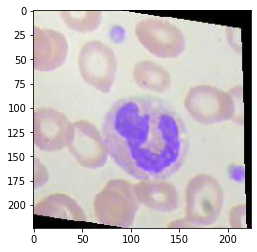

In [10]:
borrow_ang_0 = image_generator[0][0]
plt.imshow(borrow_ang_0)
mag, ang_borrow = compute_mag_phase(borrow_ang_0)
del mag

In [0]:
def transformx(img, ang_borrow):
    mag,ang = compute_mag_phase(img)
    del ang
    im = reconstruct(mag,ang_borrow)
    return im 


def reconstructAll(imgArray, ang_borrow):
    batch = np.zeros(imgArray.shape)
    for i in range(0,imgArray.shape[0]):
      imgx = imgArray[i,:,:,:]
      batch[i,:,:,:] = transformx(imgArray[i,:,:,:], ang_borrow)
    return batch

In [0]:
dataset_loader.set_image_transformations(reconstructAll)

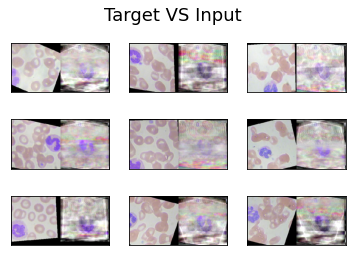

In [13]:
random_batch = dataset_loader.get_random_batch(batch_size=9, borrow_ang= ang_borrow)

# Repeat last dimension for visualization
tmp = np.repeat(random_batch[1], 1, axis=3)

N=3
start_val = 0
fig, axes = plt.subplots(N,N)
plt.suptitle('Target VS Input', fontsize=18)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    im = np.concatenate((random_batch[0][idx], tmp[idx]), 1)
    axes[row,col].imshow(np.clip(im, 0, 1))
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

Test

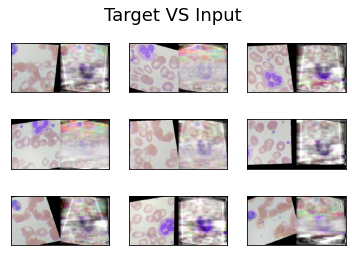

In [14]:
random_batch = dataset_loader.get_random_batch(batch_size=9, is_training = False, is_testing=True ,borrow_ang= ang_borrow)

# Repeat last dimension for visualization
tmp = np.repeat(random_batch[1], 1, axis=3)

N=3
start_val = 0
fig, axes = plt.subplots(N,N)
plt.suptitle('Target VS Input', fontsize=18)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    im = np.concatenate((random_batch[0][idx], tmp[idx]), 1)
    axes[row,col].imshow(np.clip(im, 0, 1))
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

Valid

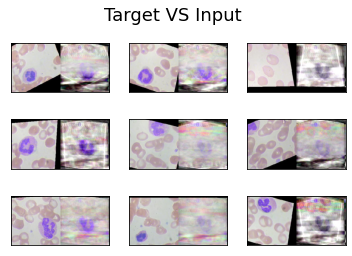

In [15]:
random_batch = dataset_loader.get_random_batch(batch_size=9, is_training = False, is_testing=False ,borrow_ang= ang_borrow)

# Repeat last dimension for visualization
tmp = np.repeat(random_batch[1], 1, axis=3)

N=3
start_val = 0
fig, axes = plt.subplots(N,N)
plt.suptitle('Target VS Input', fontsize=18)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    im = np.concatenate((random_batch[0][idx], tmp[idx]), 1)
    axes[row,col].imshow(np.clip(im, 0, 1))
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

In [0]:
from keras.layers import Dropout, merge, concatenate, UpSampling2D, MaxPooling2D
from keras.layers import Conv2D, Dense, Reshape, Flatten, Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Conv2D, Input, Dense, Reshape, Flatten
from keras.optimizers import Adam

from segmentation_models import Xnet 

# Xnet

def build_UNET(im_shape):  
  img_B = Input(shape=(im_shape[0], im_shape[1], 3))

 #model = Model(inputs = img_B, outputs = out, name='generator')
  model = Xnet(backbone_name='densenet201',input_shape=(224, 224, 3), encoder_weights='imagenet', decoder_block_type='transpose',classes=3, activation='sigmoid')
               #'upsampling')
               #'transpose')
  #model = PSPNet(backbone_name='vgg16',input_shape=(240, 240, 3), encoder_weights='imagenet',final_interpolation = 'duc')
          
  return model

In [15]:
im_shape = (224, 224)
UNET = build_UNET(im_shape)

image_in = Input(shape=(im_shape[0], im_shape[1], 3))

image_out = UNET(image_in)

UNET_MODEL = Model(inputs=image_in, outputs=image_out)
UNET_MODEL.compile(optimizer = 'Adam', loss = 'mean_absolute_error', metrics = ['mae'])



Instructions for updating:
If using Keras pass *_constraint arguments to layers.


74842112/74836368 [==============================] - 2s 0us/step


In [0]:
def showColoredIms(A, B, C):
  
  plt.subplot(131)
  plt.imshow(np.clip(A[1], 0, 1)) 
  plt.title('Input', fontsize=20)
  plt.gca().set_xticks([])
  plt.gca().set_yticks([])
  plt.subplot(132)
  plt.imshow(np.clip(B[1], 0, 1)) 
  plt.title('Output', fontsize=20)
  plt.gca().set_xticks([])
  plt.gca().set_yticks([])
  plt.subplot(133)
  plt.imshow(np.clip(C[1], 0, 1))
  plt.title('Target', fontsize=20)
  plt.gca().set_xticks([])
  plt.gca().set_yticks([])
  plt.show()



In [19]:
validation_err_graph = []
train_err_graph = []

num_epochs = 50
batch_size = 16
early_stopping = 50
n_batches = dataset_loader.get_num_batches(batch_size)
n_batches2 = dataset_loader.get_num_batches(batch_size, is_training=False, is_testing=False) #validation

low_v_err = 100   
counter = 0
for epoch in range(num_epochs):
  
  start_time = datetime.datetime.now()
  
  # Record average losses. Monitorize the loss function. 
  g_avg_loss = []
  v_avg_loss = []

  # load_batch() returns a batch generator
  # Before starting the epoch, it shuffles the dataset
  for batch_i, [imgs_A, imgs_B] in enumerate(dataset_loader.load_batch(batch_size, borrow_ang= ang_borrow)):
    #imgs_A = imgs_A[:,:,:,0]
    imgs_A = imgs_A.reshape(16,224,224,3)

    g_loss = UNET_MODEL.train_on_batch(imgs_B, imgs_A)

    fake_A = UNET.predict(imgs_B)      


    g_avg_loss.append(g_loss[0])
    
    elapsed_time = datetime.datetime.now() - start_time
    
    # Aproximation of epoch remaining time
    remaining_time = (elapsed_time/(batch_i+1)) * (n_batches-batch_i-1)

    # Plot examples          
    if batch_i%5 == 0:
      showColoredIms(imgs_B, fake_A, imgs_A)      

    # Plot the progress
    if batch_i%1 == 0:          
      print ("[Epoch %d/%d] [Batch %d/%d]  [G loss: %f] elapsed_time: %s  remaining_time: %s" % (epoch, num_epochs,
              batch_i, n_batches, np.mean(g_avg_loss), elapsed_time, remaining_time))            
  
  train_err_graph.append(np.mean(g_avg_loss))
  #validation error
  for batch_i, [imgs_A, imgs_B] in enumerate(dataset_loader.load_batch(batch_size, is_training=False, is_testing=False, borrow_ang= ang_borrow)):
    #imgs_A = imgs_A[:,:,:,0]
    imgs_A = imgs_A.reshape(16,224,224,3)  
    v_loss = UNET_MODEL.evaluate(imgs_B,imgs_A)
    v_avg_loss.append(v_loss[0])
    if batch_i%1 == 0:          
        print ("[Validating Epoch %d/%d] [Validating Batch %d/%d]  [G loss: %f] " % (epoch, num_epochs,
              batch_i, n_batches2, np.mean(v_avg_loss)))  
        

  current_v_err = np.mean(v_avg_loss)
  validation_err_graph.append(current_v_err)
  if current_v_err > low_v_err:
    counter = counter + 1
  else:
    low_v_err = current_v_err
    counter = 0 
    UNET.save_weights('/content/gdrive/My Drive/lowestvalid.h5')


  print(counter)
  if counter >= early_stopping:
    break
  
#compute validation error

Output hidden; open in https://colab.research.google.com to view.

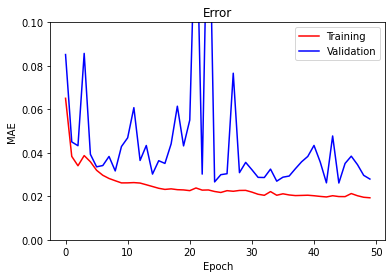

In [0]:
from matplotlib import pyplot as plt 

plt.subplot(111)
plt.title("Error") 
plt.xlabel("Epoch") 
plt.ylabel("MAE") 
plt.ylim([0, 0.1])
plt.plot(train_err_graph, 'r') 
plt.plot(validation_err_graph, 'b') 
plt.legend(['Training','Validation'])
plt.show()

Load lowest validation set weights

In [0]:
UNET.load_weights('/content/gdrive/My Drive/lowestvalid.h5')

In [0]:
from skimage.measure import compare_ssim



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


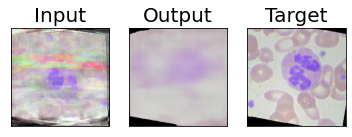

0
16/16 [==============================] - 24s 2s/step
 [Testing Batch 0/74]  [T loss: 0.165379] [T SSIM: 0.405102]
1
16/16 [==============================] - 20s 1s/step
 [Testing Batch 1/74]  [T loss: 0.145286] [T SSIM: 0.446634]
2
16/16 [==============================] - 21s 1s/step
 [Testing Batch 2/74]  [T loss: 0.145621] [T SSIM: 0.428855]
3
16/16 [==============================] - 20s 1s/step
 [Testing Batch 3/74]  [T loss: 0.146392] [T SSIM: 0.426905]
4
16/16 [==============================] - 20s 1s/step
 [Testing Batch 4/74]  [T loss: 0.144810] [T SSIM: 0.430437]


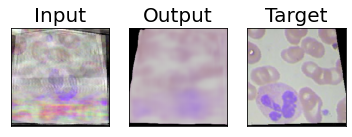

5
16/16 [==============================] - 21s 1s/step
 [Testing Batch 5/74]  [T loss: 0.141170] [T SSIM: 0.438910]
6
16/16 [==============================] - 20s 1s/step
 [Testing Batch 6/74]  [T loss: 0.143647] [T SSIM: 0.431632]
7
16/16 [==============================] - 20s 1s/step
 [Testing Batch 7/74]  [T loss: 0.143752] [T SSIM: 0.434226]
8
16/16 [==============================] - 20s 1s/step
 [Testing Batch 8/74]  [T loss: 0.143960] [T SSIM: 0.428880]
9
16/16 [==============================] - 20s 1s/step
 [Testing Batch 9/74]  [T loss: 0.142248] [T SSIM: 0.426448]


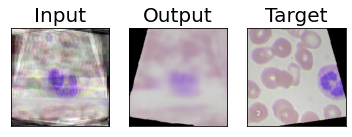

10
16/16 [==============================] - 20s 1s/step
 [Testing Batch 10/74]  [T loss: 0.142751] [T SSIM: 0.426014]
11
16/16 [==============================] - 20s 1s/step
 [Testing Batch 11/74]  [T loss: 0.142127] [T SSIM: 0.430549]
12
16/16 [==============================] - 23s 1s/step
 [Testing Batch 12/74]  [T loss: 0.142444] [T SSIM: 0.427188]
13
16/16 [==============================] - 20s 1s/step
 [Testing Batch 13/74]  [T loss: 0.142323] [T SSIM: 0.426542]
14
16/16 [==============================] - 21s 1s/step
 [Testing Batch 14/74]  [T loss: 0.142218] [T SSIM: 0.428086]


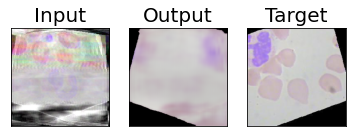

15
16/16 [==============================] - 20s 1s/step
 [Testing Batch 15/74]  [T loss: 0.140404] [T SSIM: 0.432895]
16
16/16 [==============================] - 20s 1s/step
 [Testing Batch 16/74]  [T loss: 0.140234] [T SSIM: 0.431896]
17
16/16 [==============================] - 20s 1s/step
 [Testing Batch 17/74]  [T loss: 0.140884] [T SSIM: 0.431626]
18
16/16 [==============================] - 21s 1s/step
 [Testing Batch 18/74]  [T loss: 0.140972] [T SSIM: 0.430160]
19
16/16 [==============================] - 20s 1s/step
 [Testing Batch 19/74]  [T loss: 0.142274] [T SSIM: 0.429257]


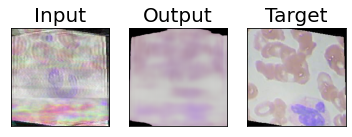

20
16/16 [==============================] - 20s 1s/step
 [Testing Batch 20/74]  [T loss: 0.142405] [T SSIM: 0.427279]
21
16/16 [==============================] - 21s 1s/step
 [Testing Batch 21/74]  [T loss: 0.141834] [T SSIM: 0.427946]
22
16/16 [==============================] - 20s 1s/step
 [Testing Batch 22/74]  [T loss: 0.142033] [T SSIM: 0.427475]
23
16/16 [==============================] - 20s 1s/step
 [Testing Batch 23/74]  [T loss: 0.141401] [T SSIM: 0.428910]
24
16/16 [==============================] - 20s 1s/step
 [Testing Batch 24/74]  [T loss: 0.142720] [T SSIM: 0.428006]


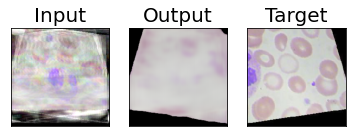

25
16/16 [==============================] - 23s 1s/step
 [Testing Batch 25/74]  [T loss: 0.143172] [T SSIM: 0.428271]
26
16/16 [==============================] - 20s 1s/step
 [Testing Batch 26/74]  [T loss: 0.144652] [T SSIM: 0.426492]
27
16/16 [==============================] - 20s 1s/step
 [Testing Batch 27/74]  [T loss: 0.145009] [T SSIM: 0.424146]
28
16/16 [==============================] - 21s 1s/step
 [Testing Batch 28/74]  [T loss: 0.145328] [T SSIM: 0.424038]
29
16/16 [==============================] - 21s 1s/step
 [Testing Batch 29/74]  [T loss: 0.145760] [T SSIM: 0.424070]


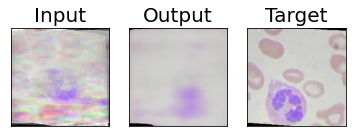

30
16/16 [==============================] - 20s 1s/step
 [Testing Batch 30/74]  [T loss: 0.144935] [T SSIM: 0.425871]
31
16/16 [==============================] - 21s 1s/step
 [Testing Batch 31/74]  [T loss: 0.145579] [T SSIM: 0.424608]
32
16/16 [==============================] - 20s 1s/step
 [Testing Batch 32/74]  [T loss: 0.145380] [T SSIM: 0.424406]
33
16/16 [==============================] - 20s 1s/step
 [Testing Batch 33/74]  [T loss: 0.145366] [T SSIM: 0.425230]
34
16/16 [==============================] - 21s 1s/step
 [Testing Batch 34/74]  [T loss: 0.145774] [T SSIM: 0.425101]


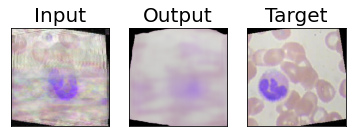

35
16/16 [==============================] - 21s 1s/step
 [Testing Batch 35/74]  [T loss: 0.146135] [T SSIM: 0.424426]
36
16/16 [==============================] - 20s 1s/step
 [Testing Batch 36/74]  [T loss: 0.146111] [T SSIM: 0.423428]
37
16/16 [==============================] - 20s 1s/step
 [Testing Batch 37/74]  [T loss: 0.146089] [T SSIM: 0.422498]
38
16/16 [==============================] - 21s 1s/step
 [Testing Batch 38/74]  [T loss: 0.146783] [T SSIM: 0.421146]
39
16/16 [==============================] - 20s 1s/step
 [Testing Batch 39/74]  [T loss: 0.145107] [T SSIM: 0.425346]


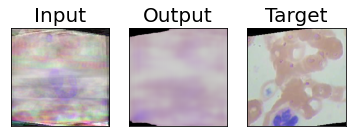

40
16/16 [==============================] - 21s 1s/step
 [Testing Batch 40/74]  [T loss: 0.143244] [T SSIM: 0.431305]
41
16/16 [==============================] - 20s 1s/step
 [Testing Batch 41/74]  [T loss: 0.141558] [T SSIM: 0.435910]
42
16/16 [==============================] - 20s 1s/step
 [Testing Batch 42/74]  [T loss: 0.139873] [T SSIM: 0.441121]
43
16/16 [==============================] - 21s 1s/step
 [Testing Batch 43/74]  [T loss: 0.138356] [T SSIM: 0.445129]
44
16/16 [==============================] - 20s 1s/step
 [Testing Batch 44/74]  [T loss: 0.136651] [T SSIM: 0.450721]


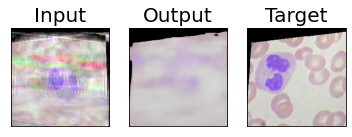

45
16/16 [==============================] - 21s 1s/step
 [Testing Batch 45/74]  [T loss: 0.135443] [T SSIM: 0.453923]
46
16/16 [==============================] - 20s 1s/step
 [Testing Batch 46/74]  [T loss: 0.134218] [T SSIM: 0.457980]
47
16/16 [==============================] - 20s 1s/step
 [Testing Batch 47/74]  [T loss: 0.133029] [T SSIM: 0.462160]
48
16/16 [==============================] - 20s 1s/step
 [Testing Batch 48/74]  [T loss: 0.131793] [T SSIM: 0.464940]
49
16/16 [==============================] - 20s 1s/step
 [Testing Batch 49/74]  [T loss: 0.130733] [T SSIM: 0.468070]


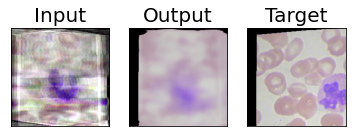

50
16/16 [==============================] - 21s 1s/step
 [Testing Batch 50/74]  [T loss: 0.129609] [T SSIM: 0.471521]
51
16/16 [==============================] - 20s 1s/step
 [Testing Batch 51/74]  [T loss: 0.128378] [T SSIM: 0.475132]
52
16/16 [==============================] - 20s 1s/step
 [Testing Batch 52/74]  [T loss: 0.127261] [T SSIM: 0.478327]
53
16/16 [==============================] - 21s 1s/step
 [Testing Batch 53/74]  [T loss: 0.126197] [T SSIM: 0.481712]
54
16/16 [==============================] - 21s 1s/step
 [Testing Batch 54/74]  [T loss: 0.125167] [T SSIM: 0.485122]


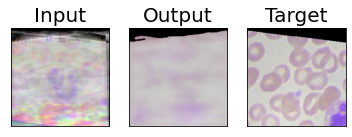

55
16/16 [==============================] - 21s 1s/step
 [Testing Batch 55/74]  [T loss: 0.124208] [T SSIM: 0.488629]
56
16/16 [==============================] - 21s 1s/step
 [Testing Batch 56/74]  [T loss: 0.123157] [T SSIM: 0.492115]
57
16/16 [==============================] - 21s 1s/step
 [Testing Batch 57/74]  [T loss: 0.122292] [T SSIM: 0.494539]
58
16/16 [==============================] - 22s 1s/step
 [Testing Batch 58/74]  [T loss: 0.121516] [T SSIM: 0.496700]
59
16/16 [==============================] - 21s 1s/step
 [Testing Batch 59/74]  [T loss: 0.120711] [T SSIM: 0.498889]


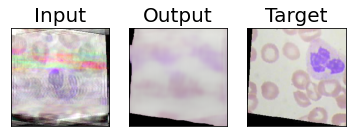

60
16/16 [==============================] - 21s 1s/step
 [Testing Batch 60/74]  [T loss: 0.119859] [T SSIM: 0.501520]
61
16/16 [==============================] - 22s 1s/step
 [Testing Batch 61/74]  [T loss: 0.119148] [T SSIM: 0.503638]
62
16/16 [==============================] - 21s 1s/step
 [Testing Batch 62/74]  [T loss: 0.118396] [T SSIM: 0.505962]
63
16/16 [==============================] - 24s 2s/step
 [Testing Batch 63/74]  [T loss: 0.117670] [T SSIM: 0.507684]
64
16/16 [==============================] - 21s 1s/step
 [Testing Batch 64/74]  [T loss: 0.116922] [T SSIM: 0.509585]


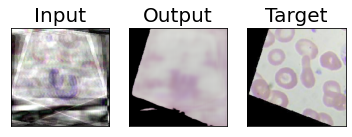

65
16/16 [==============================] - 21s 1s/step
 [Testing Batch 65/74]  [T loss: 0.116336] [T SSIM: 0.511544]
66
16/16 [==============================] - 21s 1s/step
 [Testing Batch 66/74]  [T loss: 0.115712] [T SSIM: 0.513138]
67
16/16 [==============================] - 20s 1s/step
 [Testing Batch 67/74]  [T loss: 0.115072] [T SSIM: 0.515527]
68
16/16 [==============================] - 20s 1s/step
 [Testing Batch 68/74]  [T loss: 0.114375] [T SSIM: 0.517619]
69
16/16 [==============================] - 21s 1s/step
 [Testing Batch 69/74]  [T loss: 0.113780] [T SSIM: 0.519583]


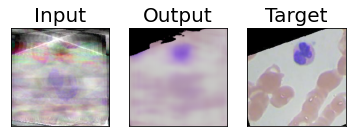

70
16/16 [==============================] - 21s 1s/step
 [Testing Batch 70/74]  [T loss: 0.113314] [T SSIM: 0.520803]
71
16/16 [==============================] - 21s 1s/step
 [Testing Batch 71/74]  [T loss: 0.112807] [T SSIM: 0.522286]
72
16/16 [==============================] - 21s 1s/step
 [Testing Batch 72/74]  [T loss: 0.112266] [T SSIM: 0.523924]
73
16/16 [==============================] - 21s 1s/step
 [Testing Batch 73/74]  [T loss: 0.111720] [T SSIM: 0.525911]


In [21]:

batch_size = 16

n_batches = dataset_loader.get_num_batches(batch_size)
n_batches2 = dataset_loader.get_num_batches(batch_size, is_training=False, is_testing=False) #validation
n_batches3 = dataset_loader.get_num_batches(batch_size, is_training=False, is_testing=True) #test
# Adversarial loss ground truths. 
# They are used as labels for the discriminator loss.
valid = np.ones((batch_size,))
fake = np.zeros((batch_size,))


t_avg_loss = []
t_avg_SSIM = []

#validation error
for batch_i, [imgs_A, imgs_B] in enumerate(dataset_loader.load_batch(batch_size, is_training=False, is_testing=True, borrow_ang= ang_borrow)):
  fake_A = UNET.predict(imgs_B) 
  (t_SSIM, _) = compare_ssim(fake_A, imgs_A, full=True, multichannel=True)
  if batch_i%5 == 0:
    showColoredIms(imgs_B, fake_A, imgs_A) 
  print(batch_i)
  t_loss = UNET_MODEL.evaluate(imgs_B,imgs_A)
  t_avg_loss.append(t_loss[0])
  t_avg_SSIM.append(t_SSIM)
  if batch_i%1 == 0:          
      print (" [Testing Batch %d/%d]  [T loss: %f] [T SSIM: %f]" % (
            batch_i, n_batches3, np.mean(t_avg_loss), np.mean(t_avg_SSIM)))  
      



# UNET RESULTS

transp MAE 0.029141 SSIM 0.927591

upsamp MAE 0.031873 SSIM 0.915871

# NEW RESULTS 50 EPOCHS including SSIM


*   VGG16


> TRANSPOSE: MAE = 0.027406 , SSIM = 0.932196 .

> UPSAMPLING: MAE = 0.029271, SSIM = 0.930247.

*   VGG19

> TRANSPOSE: MAE = 0.028709, SSIM = 0.928990 .

> UPSAMPLING: MAE = 0.030562 , SSIM =0.922063 .


*   resnet18

> TRANSPOSE: MAE = 0.026651, SSIM = 0.936682 .

> UPSAMPLING: MAE = 0.028592  , SSIM = 0.927207 .

*   resnet34 

> TRANSPOSE: MAE = 0.027094, SSIM = 0.936108  .

> UPSAMPLING: MAE =   , SSIM =  .

*   inceptionresnetv2

> TRANSPOSE: MAE = 0.026427, SSIM = 0.939611  .

> UPSAMPLING: MAE =   , SSIM =  .


*   inception 3

> TRANSPOSE: MAE = 0.025522, SSIM = 0.941839


*   densenet121

> TRANSPOSE: MAE = 0.449851, SSIM = 0.432389

* densenet 201

> TRANSPOSE: MAE = 0.024717, SSIM = 0.943776

* densenet 169

> TRANSPOSE: MAE = 0.028709, SSIM = 0.929738




# Old ignore

batch size 16

> **resnet 50** \\

*   upsampling 0.043659 got pic 
*   transpose 0.033222 got pic

> VGG 16


*   upsampling 0.06074 got pic 
*   transpose 0.108271 no pic
much less error to begin with, structure propagated through in first epoch

> VGG 19 

*   upsampling 0.18762
*   transpose 0.04583



> Indented block








  resnet 50
    upsampling 0.043659
    transpose

# PSPNET vgg16



> Bilinear interpolation 0.07373



> DUC 0.11204



